# Project Summary

**Objective:** Predict whether a material is metallic using the Matbench `is_metal` dataset.

**Dataset:** `matbench_expt_is_metal` (loaded via `matminer.datasets.load_dataset`). The notebook uses composition-based MAGPIE featurization via `matminer` and `pymatgen`.

**One-line takeaway:** Tree-based models (Random Forest / Gradient Boosting) perform well without scaling; SHAP analysis highlights elemental features driving predictions and aids interpretation.

# Supervised Learning Techniques

- Decision Trees
- Random Forests
- HistGradientBoosting Classifier
- Support Vector Machines (SVM)

### Materials Informatics

To predict/classify if material is metallic or not using Matbench 'is_metal' dataset

Matbench is an automated leaderboard for benchmarking ML algorithm predicting a diverse range of solid materials properties

What is materials informatics?
- Use of information or features regarding materials to predict their properties
- To establish processing-structure-property-performance relationship

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matminer.datasets import load_dataset
from matminer.featurizers.composition import ElementProperty
from pymatgen.core import Composition
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, f1_score, roc_auc_score, accuracy_score, confusion_matrix, roc_curve,auc
import shap

In [2]:
df=load_dataset("matbench_expt_is_metal")

In [3]:
df

,composition,is_metal
0,Ag(AuS)2,True
1,Ag(W3Br7)2,True
2,Ag0.5Ge1Pb1.75S4,False
3,Ag0.5Ge1Pb1.75Se4,False
4,Ag2BBr,True
...,...,...
4916,ZrTaN3,False
4917,ZrTe,True
4918,ZrTi2O,True
4919,ZrTiF6,True


In [4]:
df["composition_obj"]=df["composition"].apply(Composition)
# creates a new column 'composition_obj' in the dataframe 'df' which has Composition objects corresponding to the chemical formulas in the 'composition' column.

In [5]:
df.head()

,composition,is_metal,composition_obj
0,Ag(AuS)2,True,"(Ag, Au, S)"
1,Ag(W3Br7)2,True,"(Ag, W, Br)"
2,Ag0.5Ge1Pb1.75S4,False,"(Ag, Ge, Pb, S)"
3,Ag0.5Ge1Pb1.75Se4,False,"(Ag, Ge, Pb, Se)"
4,Ag2BBr,True,"(Ag, B, Br)"


In [6]:
# Apply MAGPIE-style element features
ep_feat = ElementProperty.from_preset(preset_name="magpie")
df=ep_feat.featurize_dataframe(df,"composition_obj",ignore_errors=True) # this process adds new columns to the dataframe 'df' containing the MAGPIE-style elemental features
# it takes atleast 5 minutes to run depending on the system configuration

c:\Users\suyog\anaconda3\Lib\site-packages\matminer\utils\data.py:326: UserWarning: MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)


ElementProperty:   0%|          | 0/4921 [00:00<?, ?it/s]

In [7]:
# Final dataframe with features and target variable
X = df.drop(columns="composition_obj",inplace=True)
X=df[ep_feat.feature_labels()]
X.columns=X.columns.str.replace("MagpieData ","")

In [8]:
X.head()

,minimum Number,maximum Number,range Number,mean Number,avg_dev Number,mode Number,minimum MendeleevNumber,maximum MendeleevNumber,range MendeleevNumber,mean MendeleevNumber,...,range GSmagmom,mean GSmagmom,avg_dev GSmagmom,mode GSmagmom,minimum SpaceGroupNumber,maximum SpaceGroupNumber,range SpaceGroupNumber,mean SpaceGroupNumber,avg_dev SpaceGroupNumber,mode SpaceGroupNumber
0,16.0,79.0,63.0,47.400000,25.280000,16.0,65.0,88.0,23.0,74.600000,...,0.0,0.0,0.0,0.0,70.0,225.0,155.0,163.000000,74.400000,70.0
1,35.0,74.0,39.0,46.714286,15.619048,35.0,51.0,95.0,44.0,81.000000,...,0.0,0.0,0.0,0.0,64.0,229.0,165.0,118.809524,73.079365,64.0
2,16.0,82.0,66.0,36.275862,23.552913,16.0,65.0,88.0,23.0,83.482759,...,0.0,0.0,0.0,0.0,70.0,225.0,155.0,139.482759,76.670630,70.0
3,32.0,82.0,50.0,46.206897,17.388823,34.0,65.0,89.0,24.0,84.034483,...,0.0,0.0,0.0,0.0,14.0,225.0,211.0,108.586207,104.370987,14.0
4,5.0,47.0,42.0,33.500000,14.250000,47.0,65.0,95.0,30.0,74.250000,...,0.0,0.0,0.0,0.0,64.0,225.0,161.0,170.000000,55.000000,225.0


In [9]:
X.shape

(4921, 132)

In [10]:
y=df["is_metal"]

In [11]:
selected_features = ['mean Electronegativity', 'mean AtomicWeight', 'mean Column', 'mean CovalentRadius']

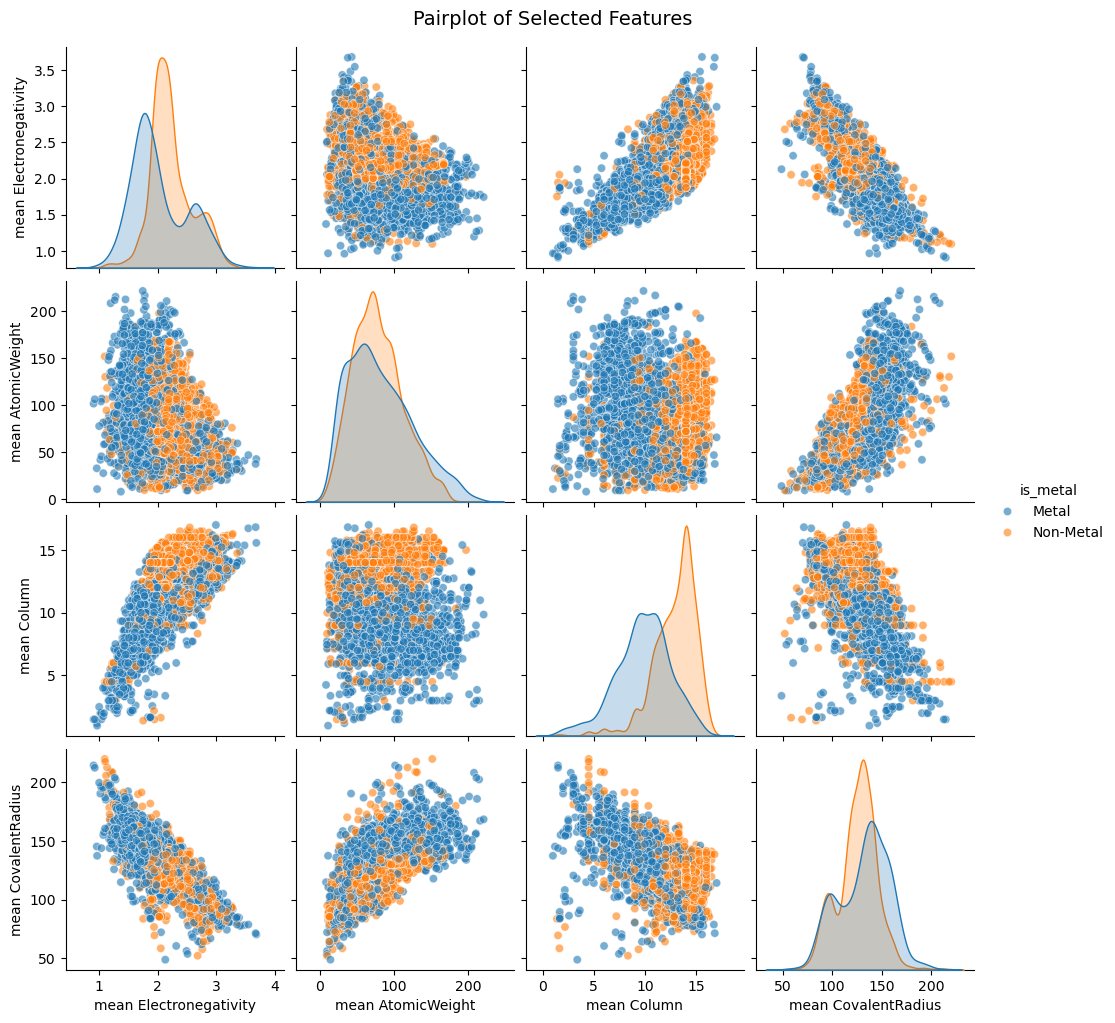

In [12]:
df_plot=X[selected_features].copy()
df_plot['is_metal']=y.map({True:'Metal',False:'Non-Metal'})

sns.pairplot(df_plot,hue='is_metal',plot_kws={'alpha':0.6})
plt.suptitle('Pairplot of Selected Features',y=1.02,fontsize=14)
plt.show()

In [13]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) # split the data into training and testing sets
# stratified sampling to maintain the class distribution in both sets

In [14]:
X_train.shape

(3444, 132)

NOTE: 
- Scaling is not necessary for tree-based models.
    - Decision trees, random forests, gradient boosting, XGBoost, and LightGBM
    Reason: They all split based on feature tresholds, not on distances or dot products
    - Tree based models are invariant to monotonic transformations like standardization or normalization (Standard Sclaer makes mean 0 and standard deviation 1)

- Scaling is needed for 
    - Support Vector Machines (SVM)
    - K-nearest neighbors (KNN)
    - Logistic regression
    - Neural Networks
    - Gaussian process models (GPR)
 

# Random Forest Classifier
- Random Forest is an ensemble method that combines multiple decision trees using bootstrap aggregation (bagging)
- Each tree is trained on a random subset of the data and features, reducing overfitting and variance

In [15]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42,n_jobs=-1)
rf_classifier.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [16]:
rf_accuracy=rf_classifier.score(X_test,y_test)
rf_accuracy

0.9140148950575491

In [17]:
y_pred=rf_classifier.predict(X_test)

### Classification Report Interpretation
- Precision: The proportion of positives that were correctly identified
- Recall (Sensitivity/TPR): The proportion of actual positives that were correctly identified
- F1-Score: The harmonic mean of precision and recall. Balances the two metrics. Useful when class distribution is imbalanced
- Support: The number of true instances of each class in the dataset

In [18]:
print(classification_report(y_test, y_pred, target_names=['Non-Metal', 'Metal']))

              precision    recall  f1-score   support

   Non-Metal       0.91      0.92      0.92       741
       Metal       0.92      0.90      0.91       736

    accuracy                           0.91      1477
   macro avg       0.91      0.91      0.91      1477
weighted avg       0.91      0.91      0.91      1477



# Gradient Boosting Classifier
- Gradient boosting classifier builds trees sequentially, where each new tree learns from the residual errors of the previous one
- Unlike bagging, it focuses on reducing bias and can achieve higher accuracy but is more prone to overfitting if not properly tuned

In [19]:
gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_classifier.fit(X_train, y_train)

,loss,'log_loss'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [20]:
gb_accuracy=gb_classifier.score(X_test,y_test)
gb_accuracy # observe that it is less than rf_accuracy

0.9092755585646581

In [21]:
y_pred = gb_classifier.predict(X_test)
y_proba = gb_classifier.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred, target_names=['Non-Metal', 'Metal']))

              precision    recall  f1-score   support

   Non-Metal       0.90      0.92      0.91       741
       Metal       0.92      0.90      0.91       736

    accuracy                           0.91      1477
   macro avg       0.91      0.91      0.91      1477
weighted avg       0.91      0.91      0.91      1477



# HistGradientBoosting Classifier

In [22]:
hgb_classifier = HistGradientBoostingClassifier(max_iter=100, learning_rate=0.1, max_depth=3, random_state=42)
hgb_classifier.fit(X_train, y_train)

,loss,'log_loss'
,learning_rate,0.1
,max_iter,100
,max_leaf_nodes,31
,max_depth,3
,min_samples_leaf,20
,l2_regularization,0.0
,max_features,1.0
,max_bins,255
,categorical_features,'from_dtype'
,monotonic_cst,None


In [23]:
hgb_accuracy=hgb_classifier.score(X_test,y_test)
hgb_accuracy

0.9011509817197021

In [24]:
y_pred=hgb_classifier.predict(X_test)
y_proba=hgb_classifier.predict_proba(X_test)[:,1]
print(classification_report(y_test, y_pred, target_names=['Non-Metal', 'Metal']))

              precision    recall  f1-score   support

   Non-Metal       0.89      0.92      0.90       741
       Metal       0.91      0.88      0.90       736

    accuracy                           0.90      1477
   macro avg       0.90      0.90      0.90      1477
weighted avg       0.90      0.90      0.90      1477



## Hyperparameter tuning with grid search
Hyperparameter tuning helps find the best parameters to improve accuracy, generalization, and robustness.

Here we will try to use important hyperparameters of Random forest model like number of trees, depth of trees, min samples per leaf, bootstrap etc

In [25]:
# First we initialize model
rf_classifier=RandomForestClassifier(random_state=42)

In [26]:
param_grid={
    'n_estimators':[100,200],
    'max_depth':[None,10,20],
    'min_samples_split':[2,5],
    'min_samples_leaf':[1,2],
    'bootstrap':[True,False]
}

In [27]:
# Set up GridSearch
grid_search=GridSearchCV(estimator=rf_classifier,
                        param_grid=param_grid, # define parameter grid
                        cv=5, # 5-fold cross-validation
                        n_jobs=-1, # utilize all available cores
                        scoring='f1', # here we use f1 score for evaluation
                        verbose=1 # verbose output
                        )

In [28]:
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'bootstrap': [True, False], 'max_depth': [None, 10, ...], 'min_samples_leaf': [1, 2], 'min_samples_split': [2, 5], ...}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,200


best hyperparameters found by GridSearch

In [29]:
grid_search.best_params_

{'bootstrap': False,
 'max_depth': 20,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 200}

In [30]:
best_rf=grid_search.best_estimator_ # get the best model from grid search

In [31]:
y_pred=best_rf.predict(X_test)
y_proba=best_rf.predict_proba(X_test)[:,1]
rf_accuracy=best_rf.score(X_test,y_test)
rf_accuracy

0.920108327691266

### Confusion Matrix

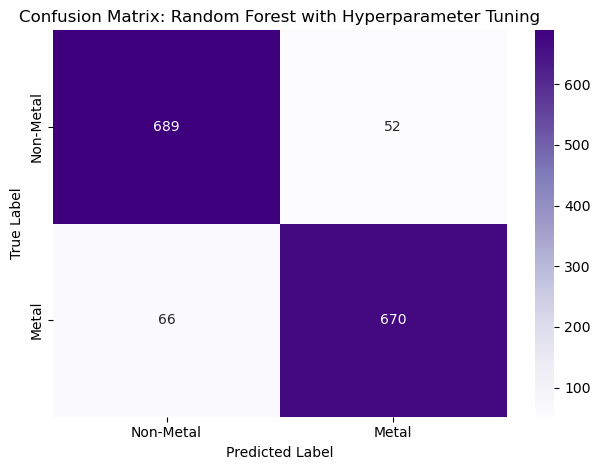

In [32]:
cm=confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Non-Metal', 'Metal'],
            yticklabels=['Non-Metal', 'Metal'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: Random Forest with Hyperparameter Tuning')
plt.tight_layout()
plt.show()

## Feature importance with SHAP for Random Forest model
- Helps to understand which input features contribute the most to a model's predictions.

- SHAP (SHapley Additive exPlanations) is a model agnostic approach based on cooperative game theory.

    - Consistent: If a model relies more on feature, SHAP assigns it higher importance

    - Interpretable: It explains how each feature pushes the prediction higher or lower

In [33]:
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test)

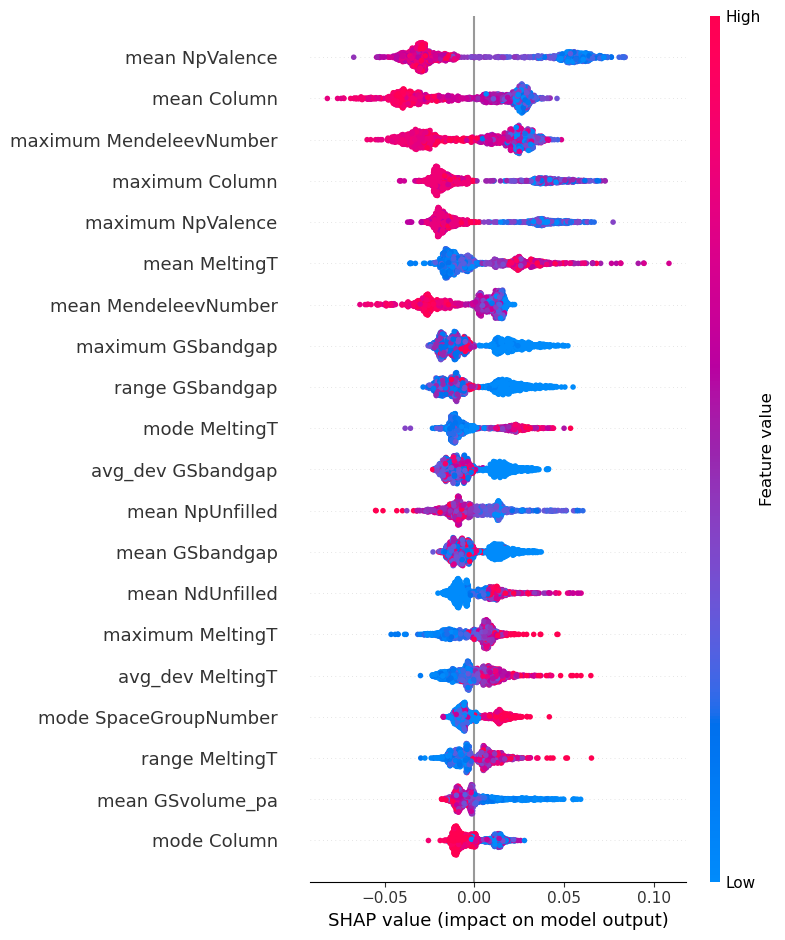

In [34]:
shap.summary_plot(shap_values[:,:,1], X_test)

- From above SHAP plot, we can see that when 'mean NpValence' is low (blue color), it contributes positively to predicting 'Metal' (higher SHAP value).
- Conversely, when 'mean NpValence' is high (red color), it contributes negatively to predicting 'Metal' (lower SHAP value).

# Support Vector Machine (SVM) Classifier
Support vector machines are supervised learning algorithms and they work by finding the optimal hyperplane that best separates data points from different classes in a high-dimentional space. The goal is to maximize the margin between classes.

- SVMs are especially effective in high-dimensional spaces
- They can handle nonlinear classification using the kernel tricks

In [35]:
svm_classifier = SVC(kernel='rbf', probability=True, random_state=42)
svm_classifier.fit(X_train, y_train)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [36]:
y_pred=svm_classifier.predict(X_test)
y_proba=svm_classifier.predict_proba(X_test)[:,1]
accuracy=svm_classifier.score(X_test,y_test)
accuracy

0.7813134732566012

In [37]:
f1_score(y_test, y_pred)

0.7824915824915825

In [38]:
roc_auc_score(y_test, y_proba)

0.8697045707915272

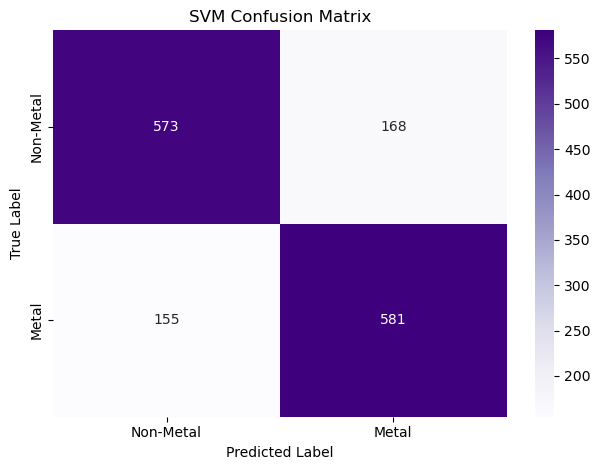

In [39]:
cm=confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Non-Metal', 'Metal'],
            yticklabels=['Non-Metal', 'Metal'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('SVM Confusion Matrix')
plt.tight_layout()
plt.show()

### Scaling the data using Standard Scaler

In [44]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [45]:
svm_classifier_scaled = SVC(kernel='rbf', probability=True, random_state=42)
svm_classifier_scaled.fit(X_train_scaled, y_train)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [52]:
y_pred=svm_classifier_scaled.predict(X_test_scaled)

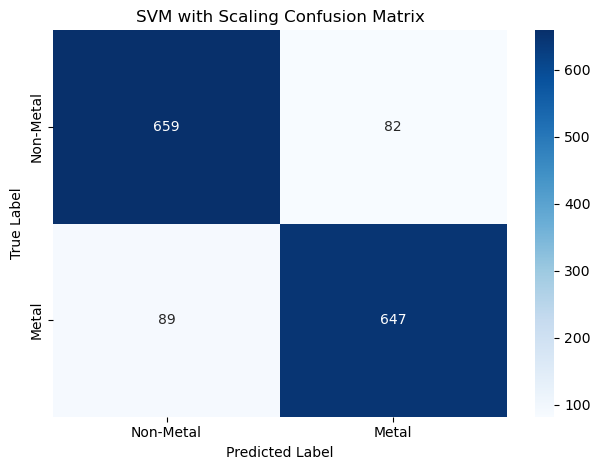

In [53]:
cm=confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Metal', 'Metal'], yticklabels=['Non-Metal', 'Metal'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('SVM with Scaling Confusion Matrix')
plt.tight_layout()
plt.show()

The model accuracy is improved after scaling which shows that the SVM model is sensitive to scaling of training data

In [54]:
f1_score(y_test, y_pred)

0.8832764505119454

In [55]:
roc_auc_score(y_test, y_proba)

0.8697045707915272

# Stochastic Gradient Based SVM Classifier

In [68]:
sgd_svm_classifer = SGDClassifier(loss="hinge", penalty="elasticnet", max_iter=1000, random_state=42)

In [69]:
sgd_svm_classifer.fit(X_train_scaled, y_train)

,loss,'hinge'
,penalty,'elasticnet'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


In [70]:
y_pred=sgd_svm_classifer.predict(X_test_scaled)
accuracy=sgd_svm_classifer.score(X_test_scaled,y_test)
accuracy

0.8293838862559242

In [71]:
f1_score(y_test, y_pred)

0.8317757009345794

In [74]:
roc_auc_score(y_test, y_pred)

0.8294415229126326

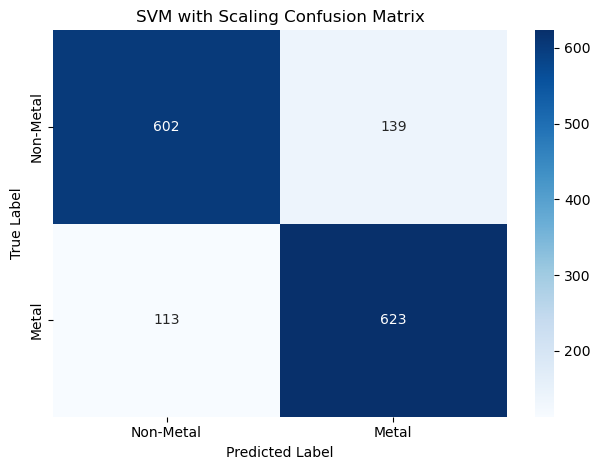

In [73]:
cm=confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Metal', 'Metal'], yticklabels=['Non-Metal', 'Metal'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('SVM with Scaling Confusion Matrix')
plt.tight_layout()
plt.show()

The original scaled SVM model is better than SGD-based model

### ROC and AUC Curve for scaled SVM model above 

In [78]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

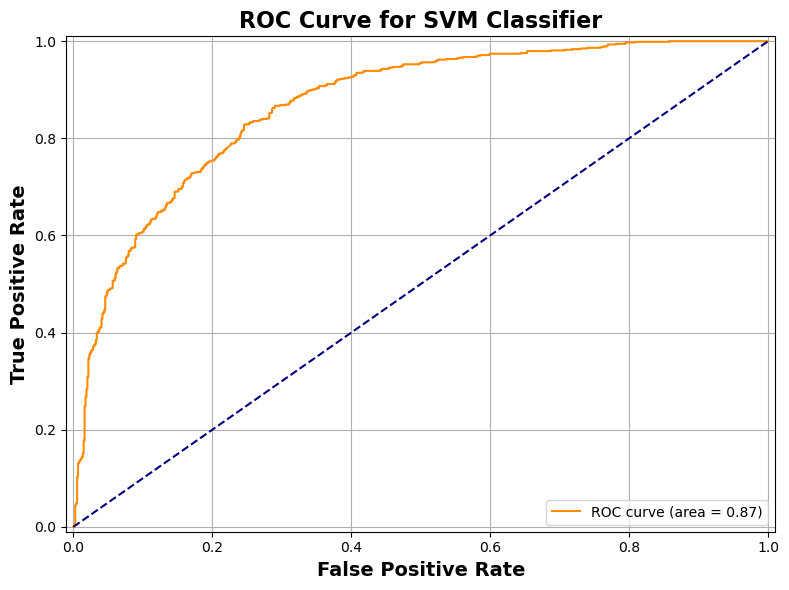

In [81]:
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel("False Positive Rate",fontsize=14,fontweight='bold')
plt.ylabel("True Positive Rate",fontsize=14,fontweight='bold')
plt.title("ROC Curve for SVM Classifier", fontsize=16,fontweight='bold')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()